In [1]:
import os
import tiktoken
import openai
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
from dotenv import load_dotenv
from openai.embeddings_utils import cosine_similarity
from tenacity import retry, wait_random_exponential, stop_after_attempt

In [2]:
from dotenv import load_dotenv
load_dotenv()
import openai

In [3]:
df = pd.read_csv('./data/data_science_jobs_indeed_usa.csv')

In [4]:
encoding = tiktoken.get_encoding('cl100k_base')

In [5]:
df = df.assign(token_count=df['Description'].apply(lambda x: len(encoding.encode(x))))

In [6]:
print(df.shape)
df.head()

(1200, 11)


,Unnamed: 0,Title,Company,Location,Rating,Date,Salary,Description,Links,Descriptions,token_count
0,0,Data Scientist,Driven Brands,"Benicia, CA",2.4,PostedPosted 26 days ago,NaN,You’ll be working alongside a team of eight an...,https://www.indeed.com/rc/clk?jk=74d176d595225...,We invite you to join us at Driven Brands!\nHe...,26
1,1,Business Analyst,Sabot Consulting,Remote,NaN,PostedPosted 4 days ago,$80 - $120 an hour,Preferred candidates will have prior experienc...,https://www.indeed.com/rc/clk?jk=f662b2efb509b...,Sabot Consulting (Sabot) is a management consu...,25
2,2,IT Business Intelligence Developer (FT) Remote...,Ballad Health,"Remote in Blountville, TN",3.0,PostedPosted 30+ days ago,NaN,Job Details Apply Save Print this job Email a…,https://www.indeed.com/rc/clk?jk=58612836c63b8...,Job Details\nApply\nSave\nPrint this job\nEmai...,10
3,3,Data Engineer,Longevity Holdings Inc.,"Remote in Minneapolis-Saint Paul, MN",NaN,PostedPosted 3 days ago,"$90,000 - $110,000 a year",Incorporate core data management competencies ...,https://www.indeed.com/company/TwentyFirst/job...,Position: Data Engineer\nLocation: MN\nAs a Da...,29
4,4,Network Administrator/dba developer,WKI Kenworth,"Wichita, KS 67219",NaN,EmployerActive 2 days ago,"$50,000 - $70,000 a year",The Network Administrator provides 2nd level e...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Full Job Description\nThe Network Administrato...,28


In [7]:
# Azure: 
# @retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(10))
# def get_embedding(text) -> list[float]:
#     text = text.replace("\n", " ")
#     return openai.Embedding.create(input=text, engine=OpenAiEmbedding)["data"][0]["embedding"]

@retry(wait=wait_random_exponential(min=1, max=20), stop=stop_after_attempt(10))
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

In [8]:
df = df.assign(embedding=df['Description'].apply(lambda x: get_embedding(x, model='text-embedding-ada-002')))

In [9]:
df.to_parquet("job_descriptions_with_embeddings.parquet")

In [10]:
df.head()

,Unnamed: 0,Title,Company,Location,Rating,Date,Salary,Description,Links,Descriptions,token_count,embedding
0,0,Data Scientist,Driven Brands,"Benicia, CA",2.4,PostedPosted 26 days ago,NaN,You’ll be working alongside a team of eight an...,https://www.indeed.com/rc/clk?jk=74d176d595225...,We invite you to join us at Driven Brands!\nHe...,26,"[-0.0194996390491724, -0.0041993726044893265, ..."
1,1,Business Analyst,Sabot Consulting,Remote,NaN,PostedPosted 4 days ago,$80 - $120 an hour,Preferred candidates will have prior experienc...,https://www.indeed.com/rc/clk?jk=f662b2efb509b...,Sabot Consulting (Sabot) is a management consu...,25,"[-0.012073525227606297, -0.026480479165911674,..."
2,2,IT Business Intelligence Developer (FT) Remote...,Ballad Health,"Remote in Blountville, TN",3.0,PostedPosted 30+ days ago,NaN,Job Details Apply Save Print this job Email a…,https://www.indeed.com/rc/clk?jk=58612836c63b8...,Job Details\nApply\nSave\nPrint this job\nEmai...,10,"[-0.021908748894929886, -0.002960818586871028,..."
3,3,Data Engineer,Longevity Holdings Inc.,"Remote in Minneapolis-Saint Paul, MN",NaN,PostedPosted 3 days ago,"$90,000 - $110,000 a year",Incorporate core data management competencies ...,https://www.indeed.com/company/TwentyFirst/job...,Position: Data Engineer\nLocation: MN\nAs a Da...,29,"[-0.017482835799455643, -0.01076465379446745, ..."
4,4,Network Administrator/dba developer,WKI Kenworth,"Wichita, KS 67219",NaN,EmployerActive 2 days ago,"$50,000 - $70,000 a year",The Network Administrator provides 2nd level e...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Full Job Description\nThe Network Administrato...,28,"[0.0011034636991098523, -0.000915585900656879,..."


In [11]:
X = np.vstack(df.embedding.values)

In [12]:
from itertools import combinations
from sklearn.utils import check_random_state
from sklearn.base import clone
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import numpy as np

def cluster_stability(X, est=None, n_iter=20, random_state=None):
    rng = check_random_state(random_state)
    labels = []
    indices = []
    est = clone(est) if est else KMeans()

    for _ in range(n_iter):
        sample_indices = rng.choice(X.shape[0], size=X.shape[0], replace=True)
        indices.append(sample_indices)
        
        if hasattr(est, "random_state"):
            est.random_state = rng.randint(np.iinfo(np.int32).max)
        
        X_bootstrap = X[sample_indices]
        est.fit(X_bootstrap)
        relabel = -np.ones(X.shape[0], dtype=np.int32)
        relabel[sample_indices] = est.labels_
        labels.append(relabel)
    
    scores = []
    for (l, i), (k, j) in combinations(zip(labels, indices), 2):
        intersect = np.intersect1d(i, j)
        scores.append(adjusted_rand_score(l[intersect], k[intersect]))

    return np.mean(scores)


In [13]:
import math
import numpy as np


def bic_score(X, labels):
    """
    Function to calculate Bayesian Information Criterion.
    
    In the BIC calculation, complexity is taken into account by adding the penalty 
    term (n_parameters / 2) * np.log(n_points) to the log-likelihood. This penalty term increases 
    as the number of parameters (model complexity) grows, and it penalizes models with more complexity. 
    Consequently, the BIC score balances the goodness of fit (log-likelihood) with the 
    model complexity (number of parameters).
  
    Args:
        X (numpy.ndarray): input data points. The shape is (n_points, n_dimensions).
        labels (list): cluster labels for the data points.

    Returns:
        bic (float): the Bayesian Information Criterion score.

    """
    # Number of Points
    n_points = len(labels)

    # Number of Clusters
    n_clusters = len(set(labels))

    # Dimension of the Input data
    n_dimensions = X.shape[1]

    # Number of parameters
    n_parameters = (n_clusters - 1) + (n_dimensions * n_clusters) + 1

    # Initial value of log likelihood
    loglikelihood = 0

    # Loop over each cluster
    for label_name in set(labels):
        # Get points for current cluster
        X_cluster = X[labels == label_name]
        n_points_cluster = len(X_cluster)

        # Calculate mean of the point cluster
        centroid = np.mean(X_cluster, axis=0)

        # Calculate variance of the point cluster
        variance = np.sum((X_cluster - centroid) ** 2) / (len(X_cluster) - 1)
        
        # Update the likelihood
        loglikelihood += \
          n_points_cluster * np.log(n_points_cluster) \
          - n_points_cluster * np.log(n_points) \
          - n_points_cluster * n_dimensions / 2 * np.log(2 * math.pi * (variance + 1e-9)) \
          - (n_points_cluster - 1) / 2

    # Calculate BIC score
    bic = loglikelihood - (n_parameters / 2) * np.log(n_points)

    return bic


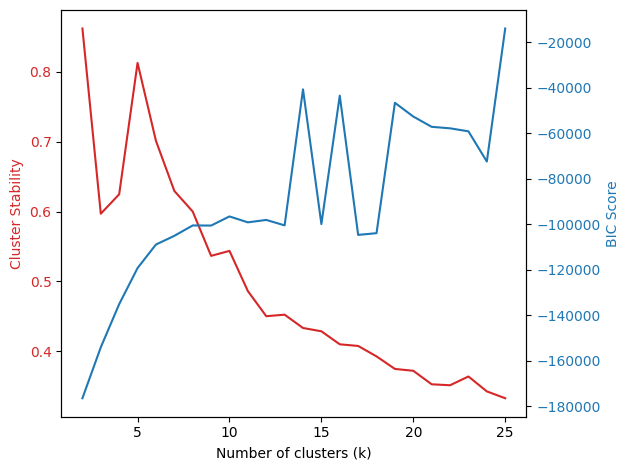

In [14]:

from matplotlib import pyplot as plt
from sklearn.cluster import KMeans

# Range of number of clusters
n_clusters_range = range(2, 26)

# Initialize lists to store results
stability_scores = []
bic_scores = []

# Loop over range of number of clusters
for n_clusters in n_clusters_range:
    # Initialize KMeans with current number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    # Fit KMeans to the dataset
    kmeans.fit(X)
    
    # Calculate cluster stability and BIC score
    stability = cluster_stability(X, est=kmeans, random_state=42)
    bic = bic_score(X, kmeans.labels_)
    
    # Append scores to lists
    stability_scores.append(stability)
    bic_scores.append(bic)

# Plot the results
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Number of clusters (k)')
ax1.set_ylabel('Cluster Stability', color=color)
ax1.plot(n_clusters_range, stability_scores, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  
color = 'tab:blue'
ax2.set_ylabel('BIC Score', color=color)  
ax2.plot(n_clusters_range, bic_scores, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()


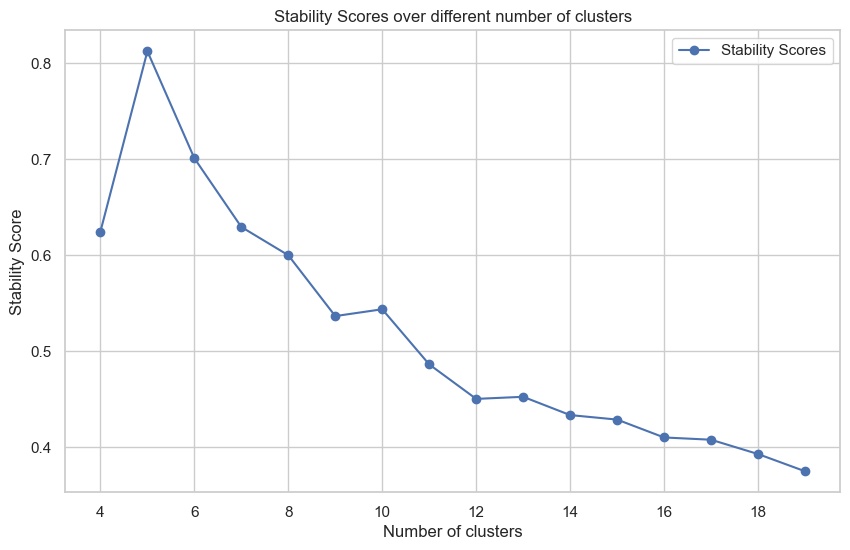

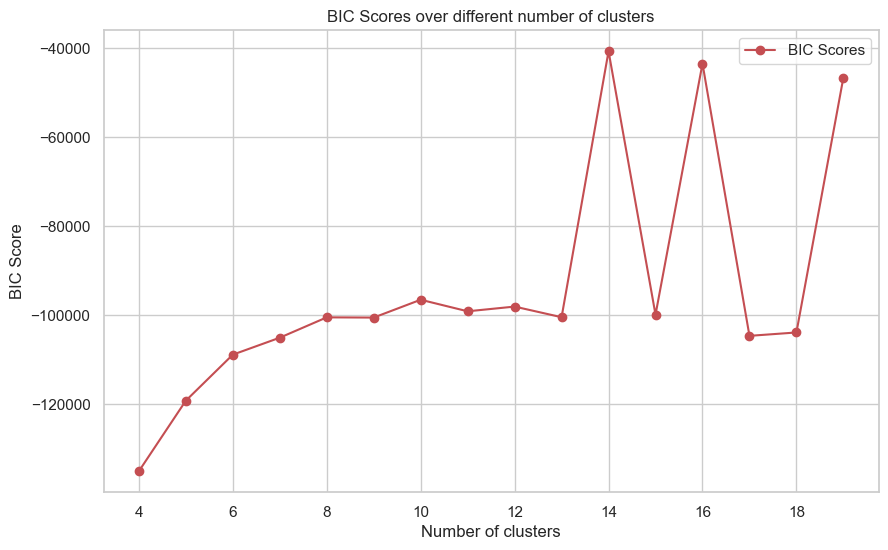

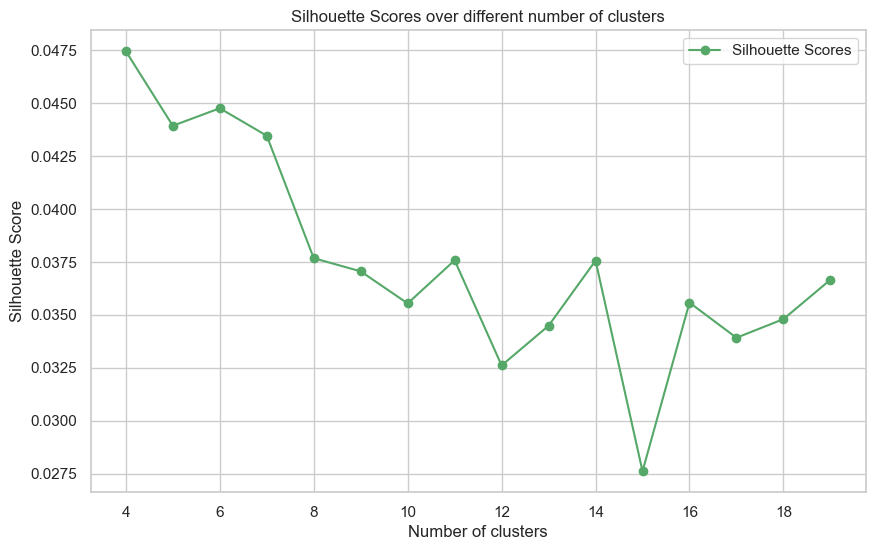

In [15]:
# Re-import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Recreate the range of number of clusters
n_clusters_range = range(4, 20)

# Recalculate the stability, BIC scores and calculate silhouette scores
stability_scores = []
bic_scores = []
silhouette_scores = []

for n_clusters in n_clusters_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    stability = cluster_stability(X, est=kmeans, random_state=42)
    bic = bic_score(X, kmeans.labels_)
    silhouette = silhouette_score(X, kmeans.labels_)
    stability_scores.append(stability)
    bic_scores.append(bic)
    silhouette_scores.append(silhouette)

# Create a DataFrame to store the results
res_df = pd.DataFrame({
    'Number of clusters': list(n_clusters_range) * 3,
    'Score': list(stability_scores) + list(bic_scores) + list(silhouette_scores),
    'Type': ['Stability'] * len(stability_scores) + ['BIC'] * len(bic_scores) + ['Silhouette'] * len(silhouette_scores)
})

# Set the style of seaborn to be whitegrid, this gives a nice clean modern look
sns.set(style="whitegrid")

# Plot Stability scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, stability_scores, marker='o', linestyle='-', color='b', label='Stability Scores')
plt.title('Stability Scores over different number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Stability Score')
plt.legend()
plt.show()

# Plot BIC scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, bic_scores, marker='o', linestyle='-', color='r', label='BIC Scores')
plt.title('BIC Scores over different number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('BIC Score')
plt.legend()
plt.show()

# Plot Silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(n_clusters_range, silhouette_scores, marker='o', linestyle='-', color='g', label='Silhouette Scores')
plt.title('Silhouette Scores over different number of clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.legend()
plt.show()


In [16]:
df.head(2)

,Unnamed: 0,Title,Company,Location,Rating,Date,Salary,Description,Links,Descriptions,token_count,embedding
0,0,Data Scientist,Driven Brands,"Benicia, CA",2.4,PostedPosted 26 days ago,NaN,You’ll be working alongside a team of eight an...,https://www.indeed.com/rc/clk?jk=74d176d595225...,We invite you to join us at Driven Brands!\nHe...,26,"[-0.0194996390491724, -0.0041993726044893265, ..."
1,1,Business Analyst,Sabot Consulting,Remote,NaN,PostedPosted 4 days ago,$80 - $120 an hour,Preferred candidates will have prior experienc...,https://www.indeed.com/rc/clk?jk=f662b2efb509b...,Sabot Consulting (Sabot) is a management consu...,25,"[-0.012073525227606297, -0.026480479165911674,..."


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['kmeans_label'] = kmeans.fit_transform(X)

In [18]:
import optuna
import umap
import hdbscan

def objective(trial):
    # Suggested parameters
    n_neighbors = trial.suggest_int('n_neighbors', 5, 50)
    min_dist = trial.suggest_float('min_dist', 0.001, 0.5)
    n_components = trial.suggest_int('n_components', 2, 6)

    min_cluster_size = trial.suggest_int('min_cluster_size', 5, 50)
    min_samples = trial.suggest_int('min_samples', 1, 50)

    # Dimensionality reduction
    reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components)
    embedding = reducer.fit_transform(X)

    # Clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, 
                                min_samples=min_samples,
                                gen_min_span_tree=True)
    labels = clusterer.fit_predict(embedding)

    # Compute silhouette score
    score = clusterer.relative_validity_

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)


[I 2023-07-19 01:42:09,538] A new study created in memory with name: no-name-e67156b7-12e1-44d6-98e9-9612204b45d6
[I 2023-07-19 01:42:12,841] Trial 0 finished with value: 0.0006389468776434006 and parameters: {'n_neighbors': 27, 'min_dist': 0.28393480127458876, 'n_components': 3, 'min_cluster_size': 50, 'min_samples': 41}. Best is trial 0 with value: 0.0006389468776434006.
[I 2023-07-19 01:42:15,616] Trial 1 finished with value: 0.10706208995065587 and parameters: {'n_neighbors': 5, 'min_dist': 0.1201659713951268, 'n_components': 2, 'min_cluster_size': 26, 'min_samples': 18}. Best is trial 1 with value: 0.10706208995065587.
[I 2023-07-19 01:42:18,670] Trial 2 finished with value: 0.203814761331619 and parameters: {'n_neighbors': 13, 'min_dist': 0.3138538871204052, 'n_components': 5, 'min_cluster_size': 25, 'min_samples': 2}. Best is trial 2 with value: 0.203814761331619.
[I 2023-07-19 01:42:21,579] Trial 3 finished with value: 0.002857061227195705 and parameters: {'n_neighbors': 5, 'mi

In [19]:
study.best_params

{'n_neighbors': 26,
 'min_dist': 0.012321667754416843,
 'n_components': 5,
 'min_cluster_size': 5,
 'min_samples': 28}

In [28]:
kmeans = KMeans(n_clusters=4, random_state=42)
df['kmeans_label'] = kmeans.fit_predict(X)

In [29]:
df.head(2)

,Unnamed: 0,Title,Company,Location,Rating,Date,Salary,Description,Links,Descriptions,token_count,embedding,kmeans_label
0,0,Data Scientist,Driven Brands,"Benicia, CA",2.4,PostedPosted 26 days ago,NaN,You’ll be working alongside a team of eight an...,https://www.indeed.com/rc/clk?jk=74d176d595225...,We invite you to join us at Driven Brands!\nHe...,26,"[-0.0194996390491724, -0.0041993726044893265, ...",2
1,1,Business Analyst,Sabot Consulting,Remote,NaN,PostedPosted 4 days ago,$80 - $120 an hour,Preferred candidates will have prior experienc...,https://www.indeed.com/rc/clk?jk=f662b2efb509b...,Sabot Consulting (Sabot) is a management consu...,25,"[-0.012073525227606297, -0.026480479165911674,...",3


In [40]:
import pandas as pd
import random
import openai
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from langchain.llms import OpenAI


class ClusterTopicIdentifier:

    def __init__(self, dataframe, text_col='Description', cluster_col='kmeans_label', engine="text-davinci-003"):
        self.dataframe = dataframe
        self.text_col = text_col
        self.cluster_col = cluster_col
        self.engine = engine

    def get_topic_label(self, text_samples):
        prompt = "Given the following text samples, provide a concise topic label:\n\n" + "\n\n".join(text_samples)
        response = openai.Completion.create(engine=self.engine, prompt=prompt, max_tokens=60)
        return response.choices[0].text.strip()
    


    def measure_similarity(self, topic_labels):
        vectorizer = TfidfVectorizer().fit_transform(topic_labels)
        vectors = vectorizer.toarray()
        csim = cosine_similarity(vectors)
        return np.mean(csim)

    def identify_topics(self, num_samples=5, sample_size=10):
        cluster_labels = {}
        clusters = self.dataframe[self.cluster_col].unique()

        for cluster in clusters:
            texts = self.dataframe[self.dataframe[self.cluster_col] == cluster][self.text_col].tolist()
            topic_labels = []
            for _ in range(num_samples):
                text_samples = random.sample(texts, min(sample_size, len(texts)))
                topic_labels.append(self.get_topic_label(text_samples))
            similarity = self.measure_similarity(topic_labels)
            cluster_labels[cluster] = (topic_labels, similarity)

        return cluster_labels

    def visualize_runs(self, cluster_labels):
        for cluster, (topic_labels, _) in cluster_labels.items():
            # Compute similarity matrix
            vectorizer = TfidfVectorizer().fit_transform(topic_labels)
            vectors = vectorizer.toarray()
            similarity_matrix = cosine_similarity(vectors)

            # Create a heatmap
            plt.figure(figsize=(10, 8))
            sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm')
            plt.title(f'Heatmap of Topic Label Similarities for Cluster {cluster}')
            plt.show()

            # Create a histogram
            plt.figure(figsize=(10, 8))
            sns.histplot(similarity_matrix.flatten(), kde=True, bins=20)
            plt.title(f'Histogram of Topic Label Similarities for Cluster {cluster}')
            plt.xlabel('Similarity Score')
            plt.ylabel('Frequency')
            plt.show()


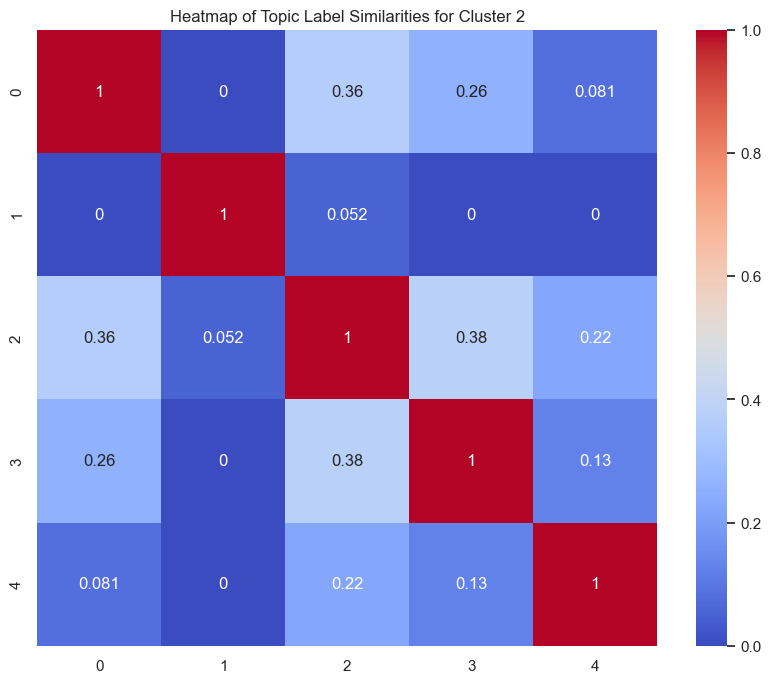

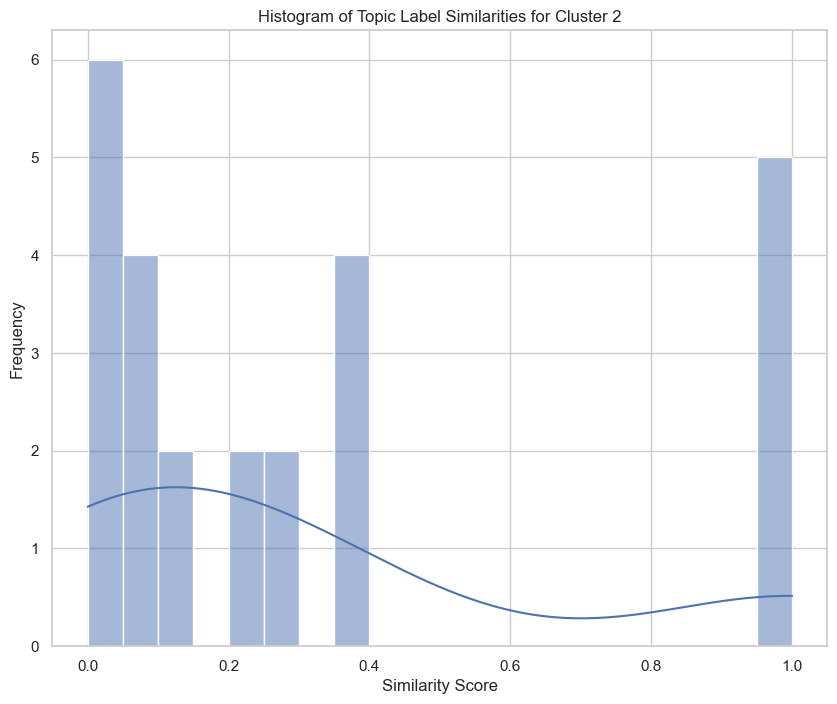

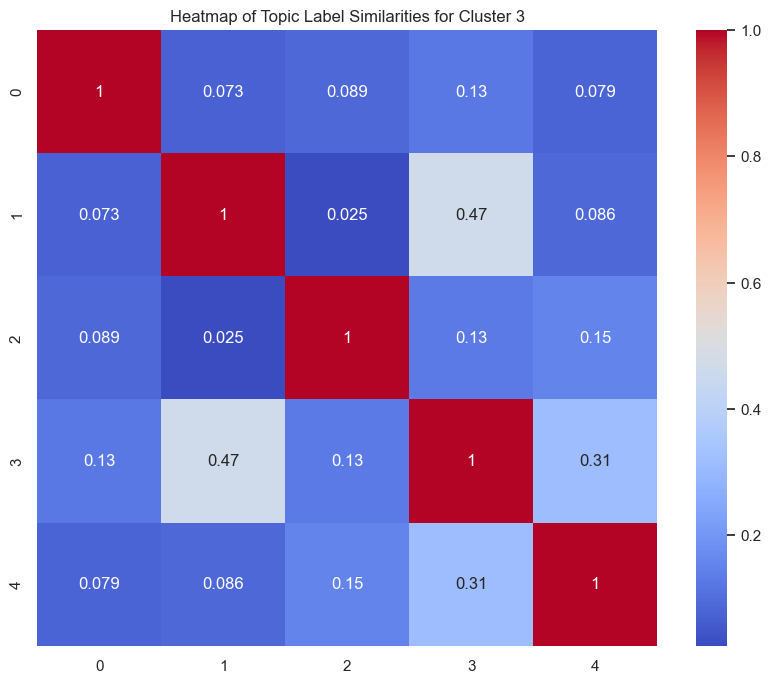

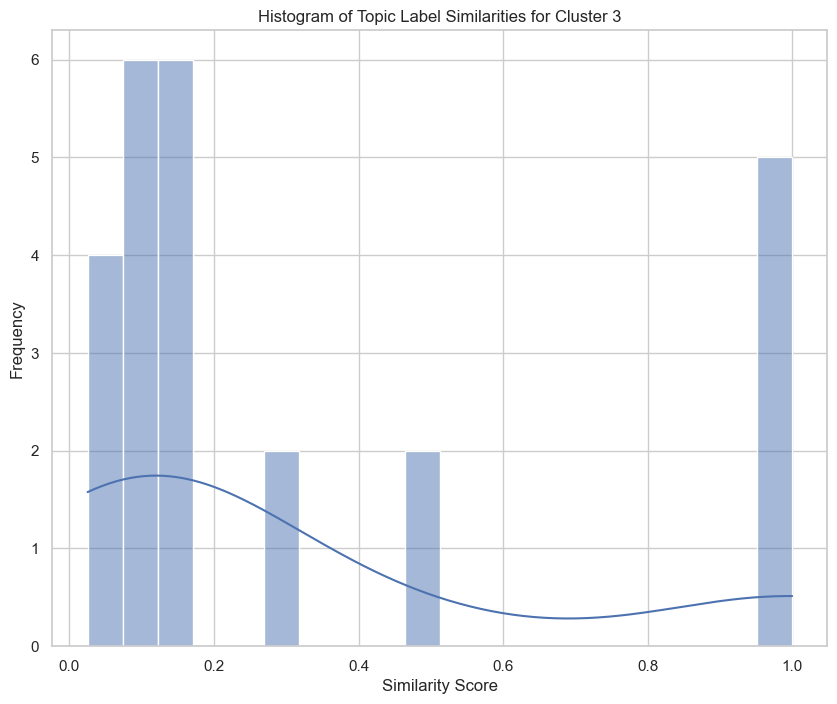

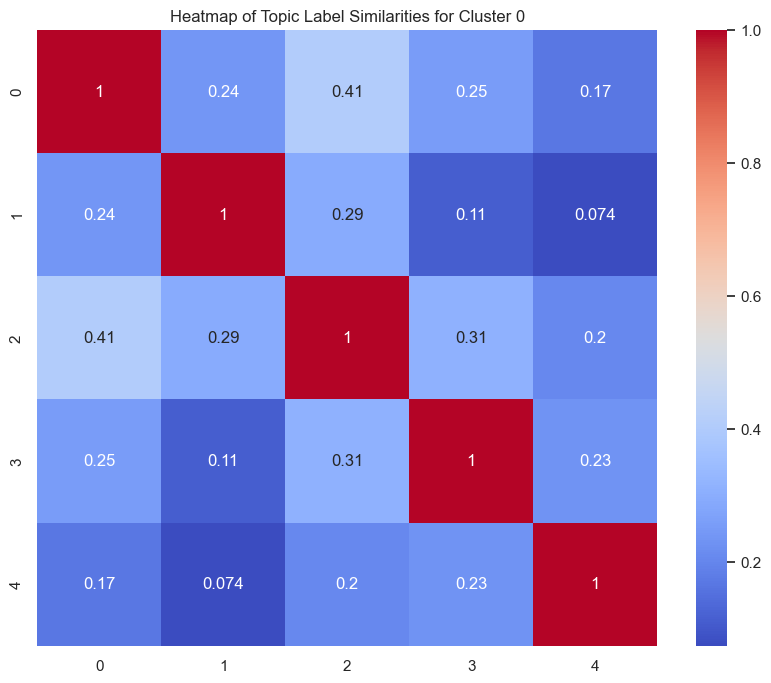

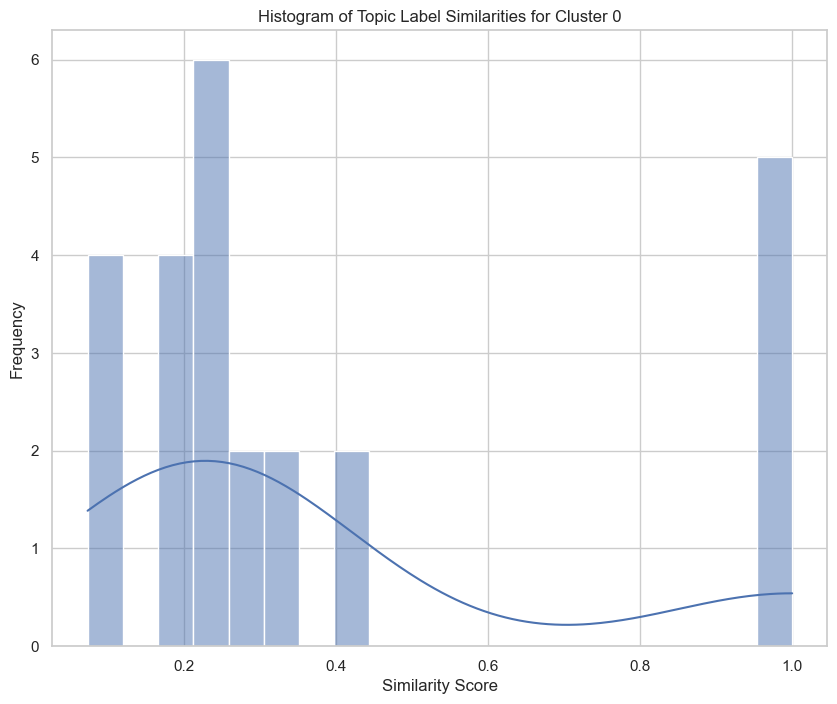

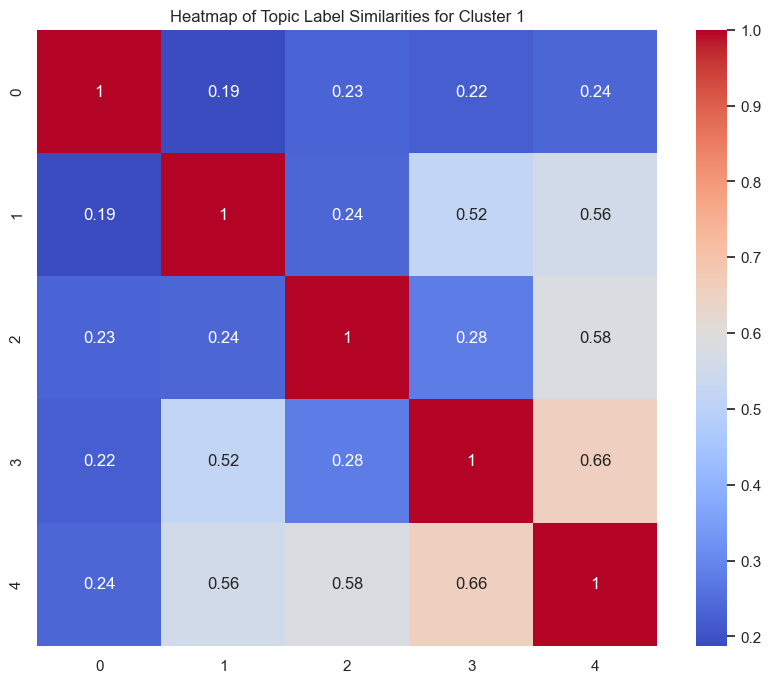

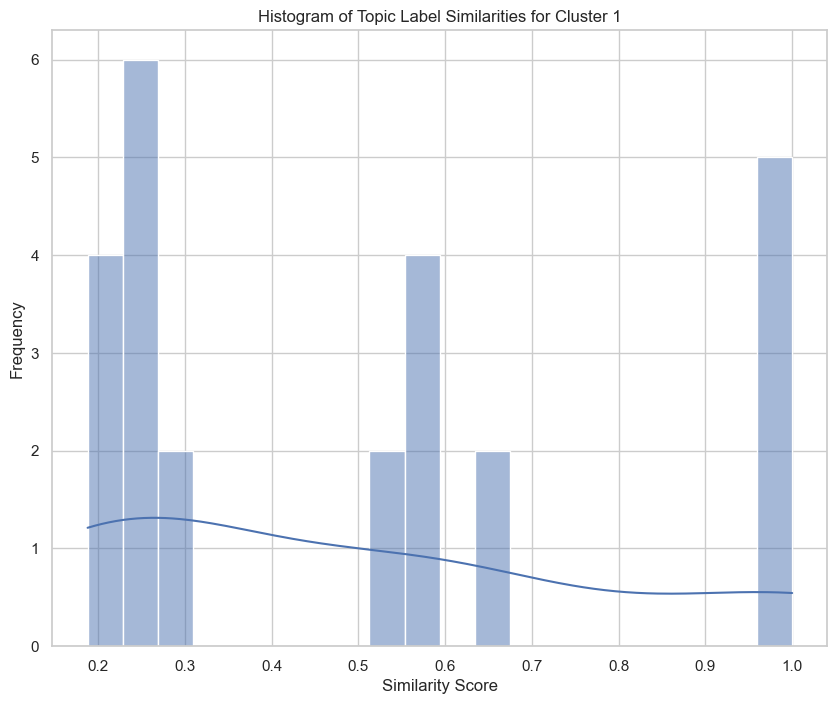

In [41]:
# Initialize the class with the toy dataset
cluster_identifier = ClusterTopicIdentifier(
    df, 
    text_col='Description', 
    cluster_col='kmeans_label', )

# Identify topics for each cluster
cluster_labels = cluster_identifier.identify_topics()

# Visualize the topic stability
cluster_identifier.visualize_runs(cluster_labels)


In [83]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import openai
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from langchain import OpenAIEmbeddings

class ClusterTopicIdentifier:
    def __init__(self, dataframe, text_col='Description', cluster_col='kmeans_label', engine="text-davinci-003"):
        self.dataframe = dataframe
        self.text_col = text_col
        self.cluster_col = cluster_col
        self.engine = engine

    def get_topic_label(self, text_samples):
        prompt = "Given the following text samples, provide a concise topic label:\n " + "\n".join(text_samples)
        response = openai.Completion.create(engine=self.engine, prompt=prompt, max_tokens=60)
        return response.choices[0].text.strip()

    def measure_similarity(self, topic_labels):
        vectorizer = TfidfVectorizer().fit_transform(topic_labels)
        vectors = vectorizer.toarray()
        csim = cosine_similarity(vectors)
        return np.mean(csim)
    
    def identify_topics(self, num_samples=5, sample_size=10):
        self.cluster_labels = {}
        clusters = self.dataframe[self.cluster_col].unique()

        for cluster in clusters:
            texts = self.dataframe[self.dataframe[self.cluster_col] == cluster][self.text_col].tolist()
            topic_labels = []
            for _ in range(num_samples):
                text_samples = random.sample(texts, min(sample_size, len(texts)))
                topic_labels.append(self.get_topic_label(text_samples))
            similarity = self.measure_similarity(topic_labels)
            self.cluster_labels[cluster] = (topic_labels, similarity)
        
        return self.cluster_labels

    def visualize_runs(self):
        for cluster, (topic_labels, _) in self.cluster_labels.items():
            vectorizer = OpenAIEmbeddings()
            vectors = vectorizer.
            similarity_matrix = cosine_similarity(vectors)

            # Create a heatmap
            plt.figure(figsize=(10, 8))
            sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm')
            plt.title(f'Heatmap of Topic Label Similarities for Cluster {cluster}')
            plt.show()

            # Create a histogram
            plt.figure(figsize=(10, 8))
            sns.histplot(similarity_matrix.flatten(), kde=True, bins=20)
            plt.title(f'Histogram of Topic Label Similarities for Cluster {cluster}')
            plt.xlabel('Similarity Score')
            plt.ylabel('Frequency')
            plt.show()


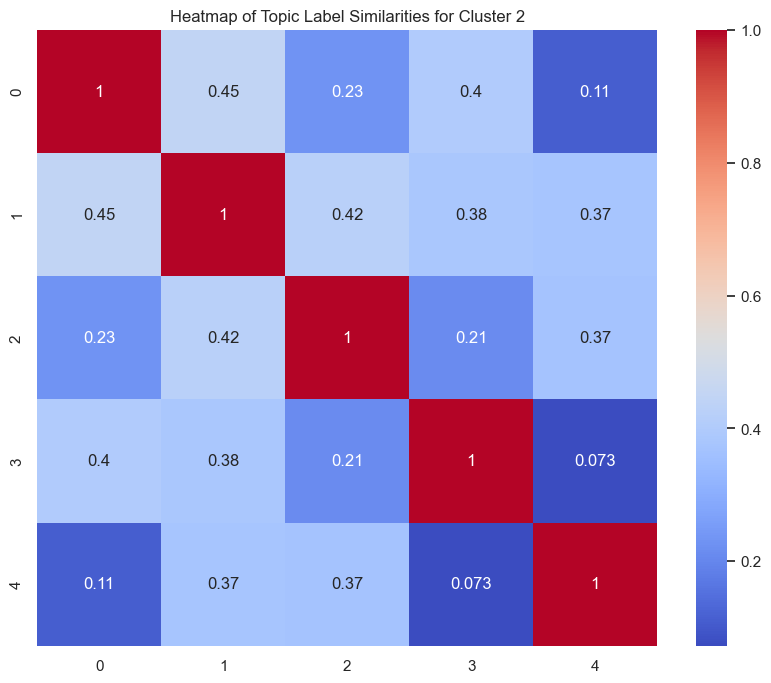

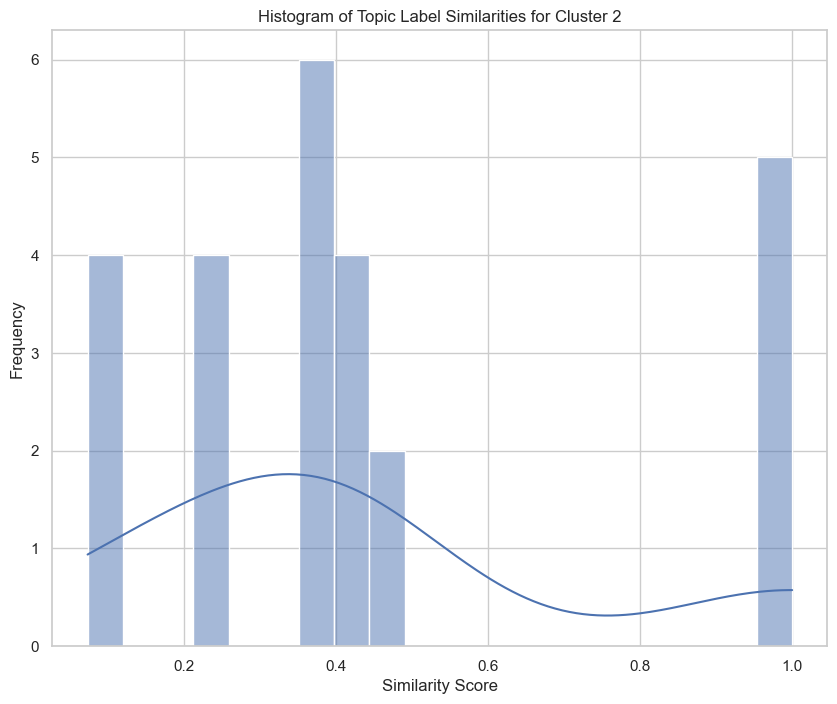

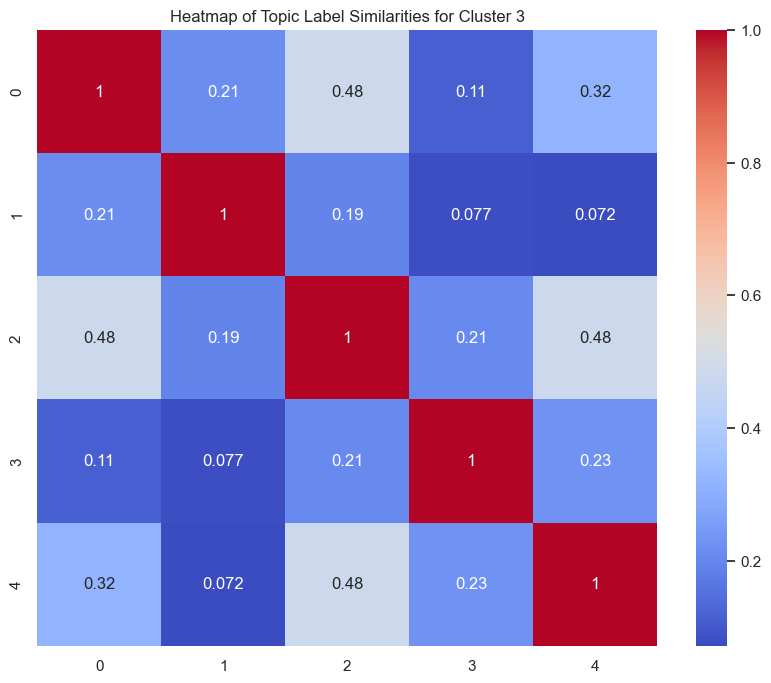

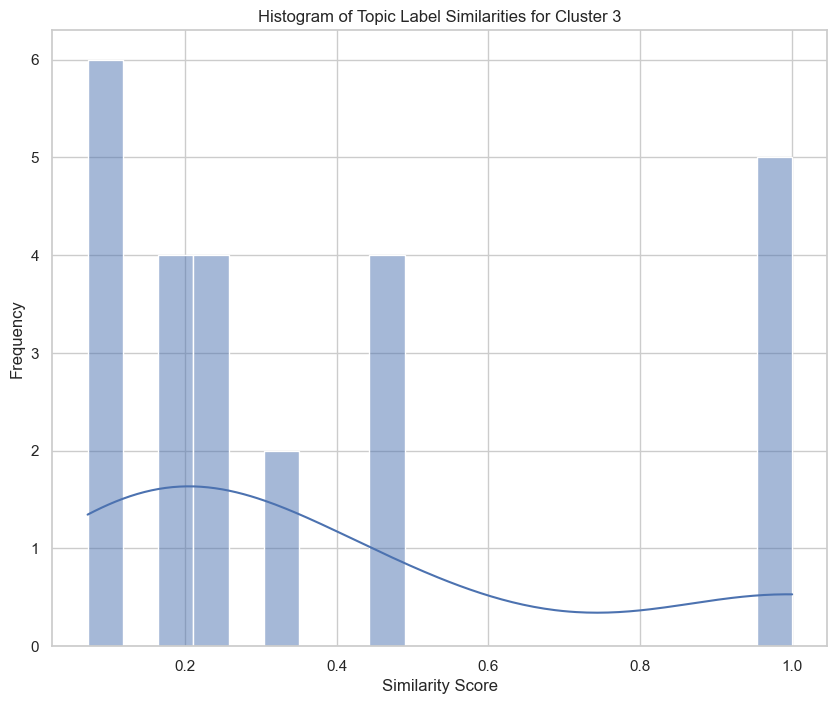

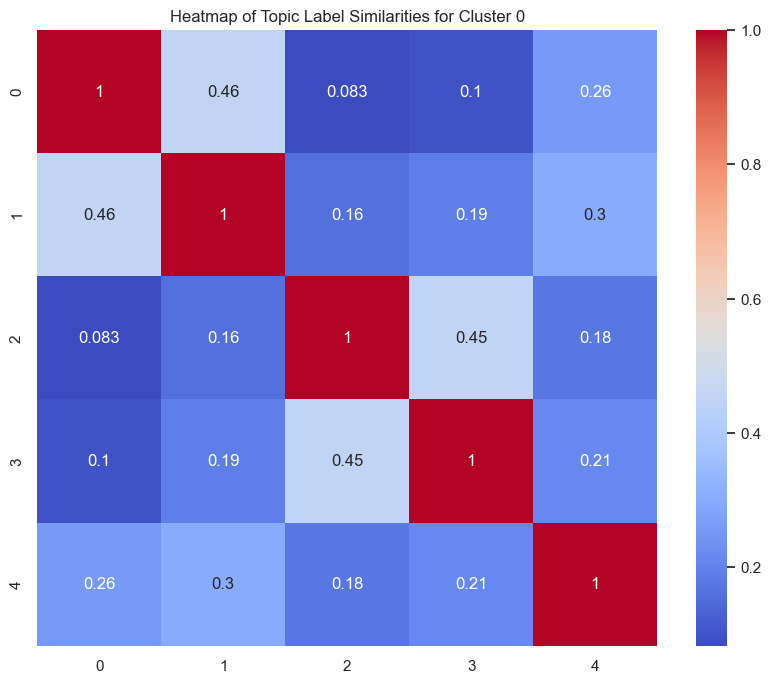

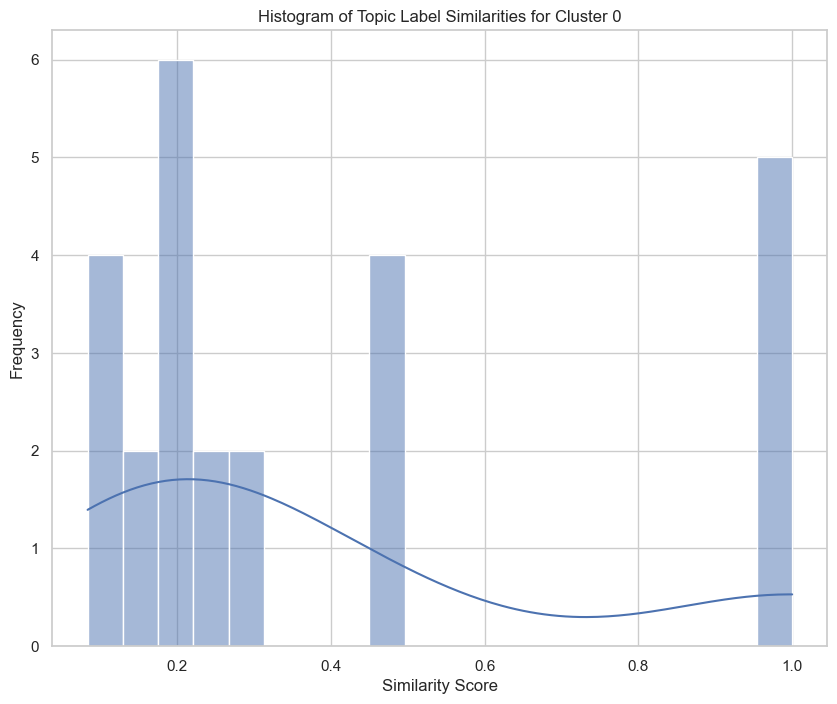

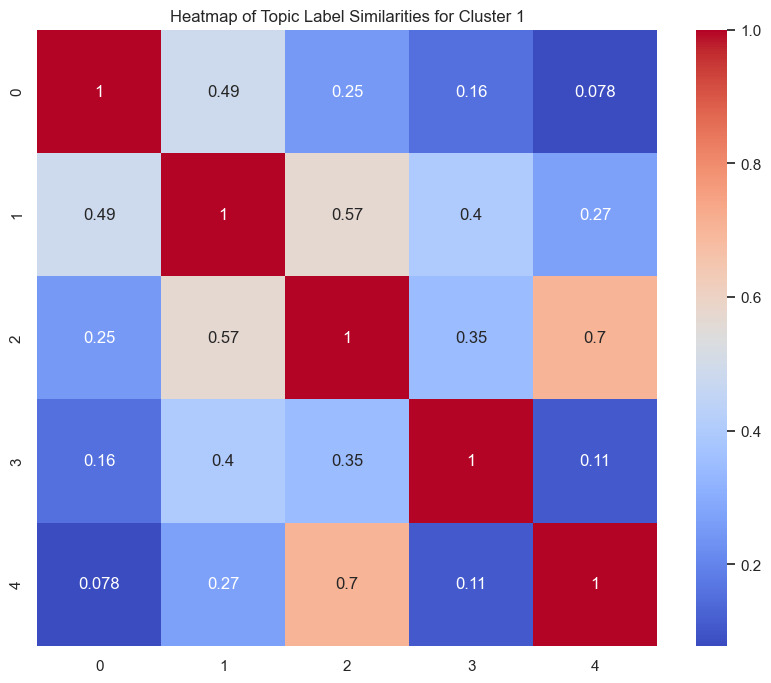

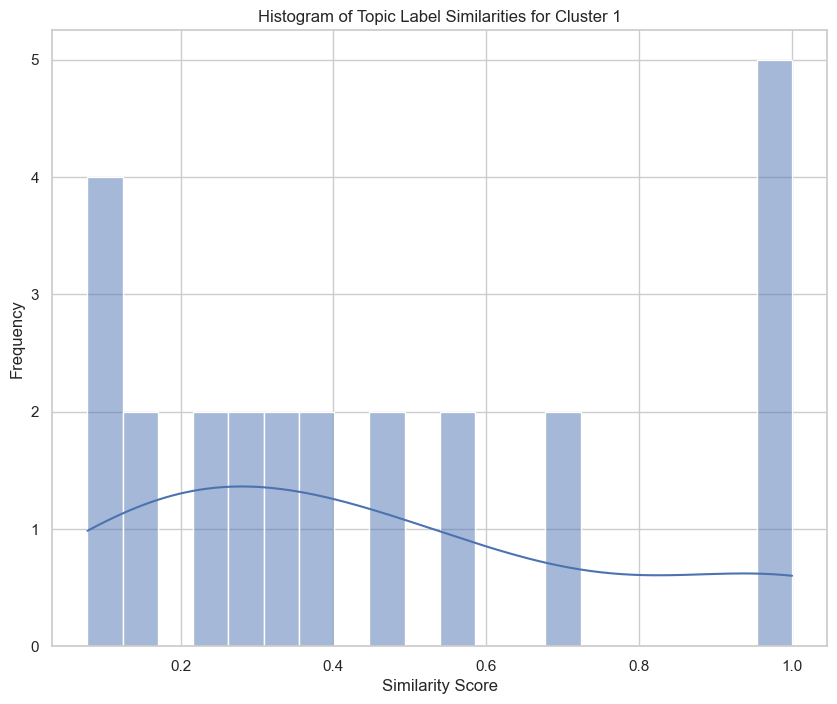

In [86]:
# Initialize the class with the toy dataset
cluster_identifier = ClusterTopicIdentifier(
    df, 
    text_col='Description', 
    cluster_col='kmeans_label', )

# Identify topics for each cluster
cluster_labels = cluster_identifier.identify_topics()

# Visualize the topic stability
cluster_identifier.visualize_runs()

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import openai
import random


class ClusterTopicIdentifier:
    def __init__(self, dataframe, text_col='text', cluster_col='cluster', engine="text-davinci-003"):
        self.dataframe = dataframe
        self.text_col = text_col
        self.cluster_col = cluster_col
        self.engine = engine

    def get_topic_label(self, text_samples):  # Missing 'self'
        prompt = "Given the following text samples, provide a concise topic label:\n\n"
        "\n".join(text_samples)
        response = openai.Completion.create(engine=self.engine, prompt=prompt, max_tokens=60)  # Use self.engine instead of hardcoded string
        return response.choices[0].text.strip()

    def measure_similarity(self, topic_labels):  # Missing 'self'
        vectorizer = TfidfVectorizer().fit_transform(topic_labels)
        vectors = vectorizer.toarray()
        csim = cosine_similarity(vectors)
        return np.mean(csim)

    def identify_topics(self, num_samples=5, sample_size=10):
        clusters = self.dataframe[self.cluster_col].unique()
        results = []

        for cluster in clusters:
            texts = self.dataframe[self.dataframe[self.cluster_col] == cluster][self.text_col].tolist()
            topic_labels = []
            for _ in range(num_samples):
                text_samples = random.sample(texts, min(sample_size, len(texts)))
                topic_labels.append(self.get_topic_label(text_samples))
            similarity = self.measure_similarity(topic_labels)
            results.append([cluster, topic_labels, similarity])

        result_df = pd.DataFrame(results, columns=['Cluster', 'Topic Labels', 'Similarity'])
        return result_df

    def visualize_runs(self, result_df):
        for i, row in result_df.iterrows():
            cluster = row['Cluster']
            topic_labels = row['Topic Labels']

            # Compute similarity matrix
            vectorizer = TfidfVectorizer().fit_transform(topic_labels)
            vectors = vectorizer.toarray()
            similarity_matrix = cosine_similarity(vectors)

            # Create a heatmap
            plt.figure(figsize=(10, 8))
            sns.heatmap(similarity_matrix, annot=True, cmap='coolwarm')
            plt.title(f'Heatmap of Topic Label Similarities for Cluster {cluster}')
            plt.show()

            # Create a histogram
            plt.figure(figsize=(10, 8))
            sns.histplot(similarity_matrix.flatten(), kde=True, bins=20)
            plt.title(f'Histogram of Topic Label Similarities for Cluster {cluster}')
            plt.xlabel('Similarity Score')
            plt.ylabel('Frequency')
            plt.show()

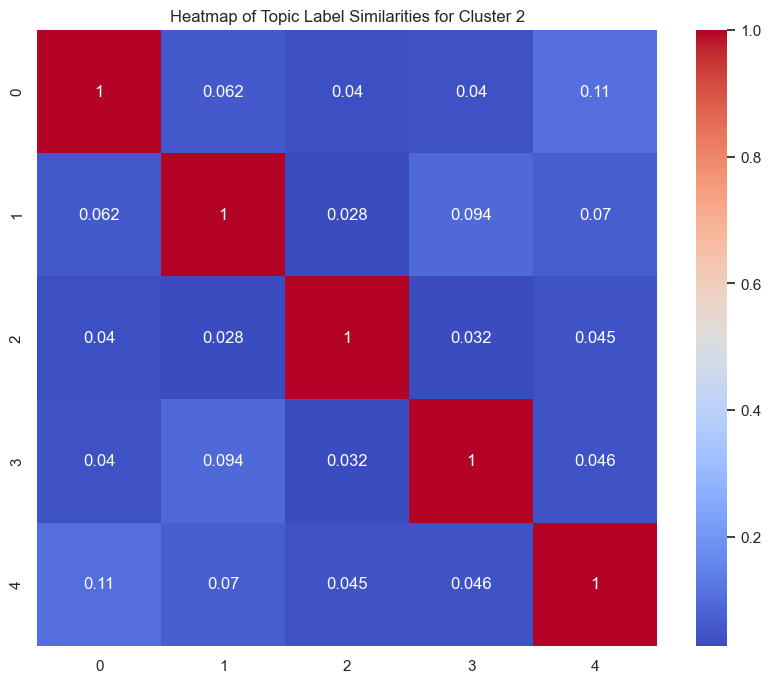

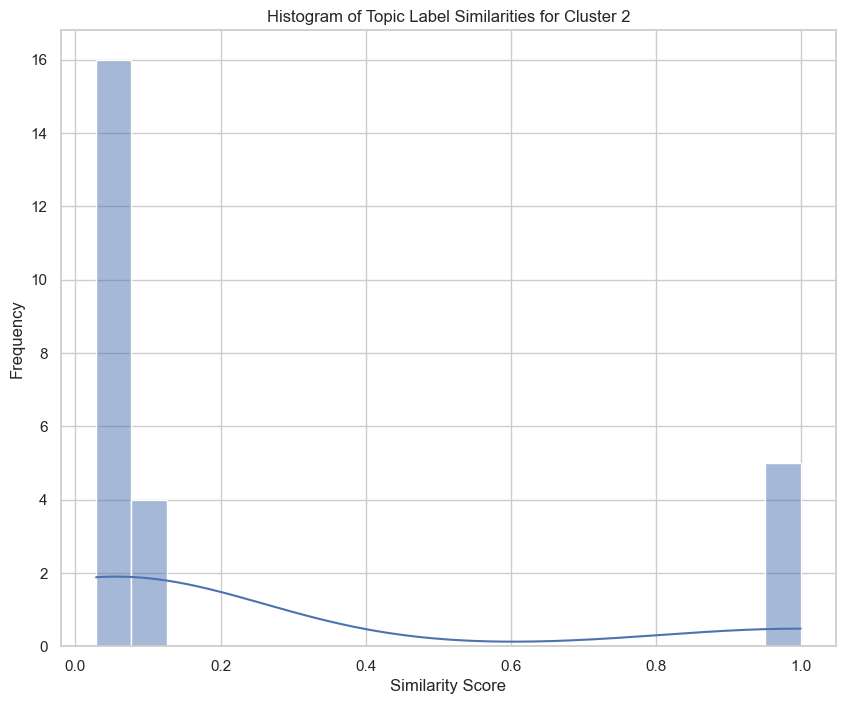

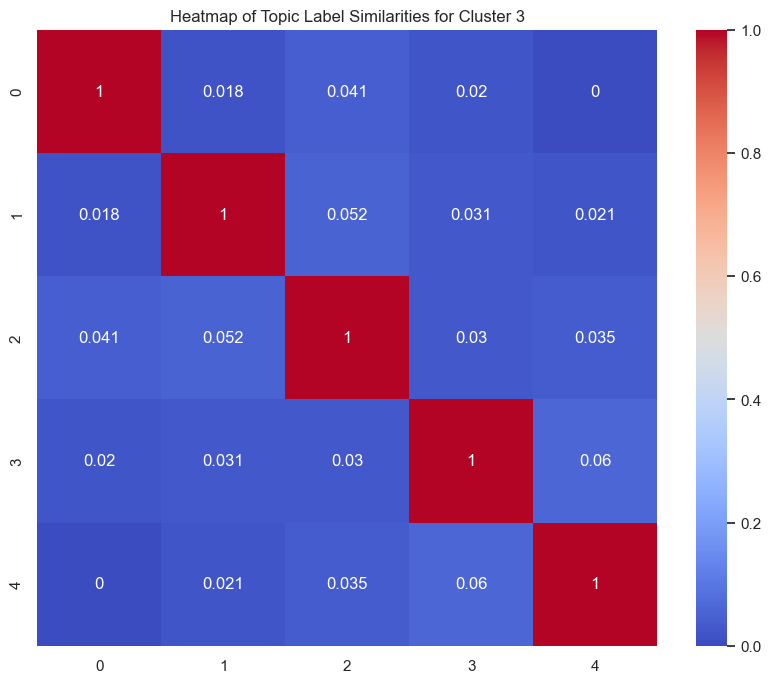

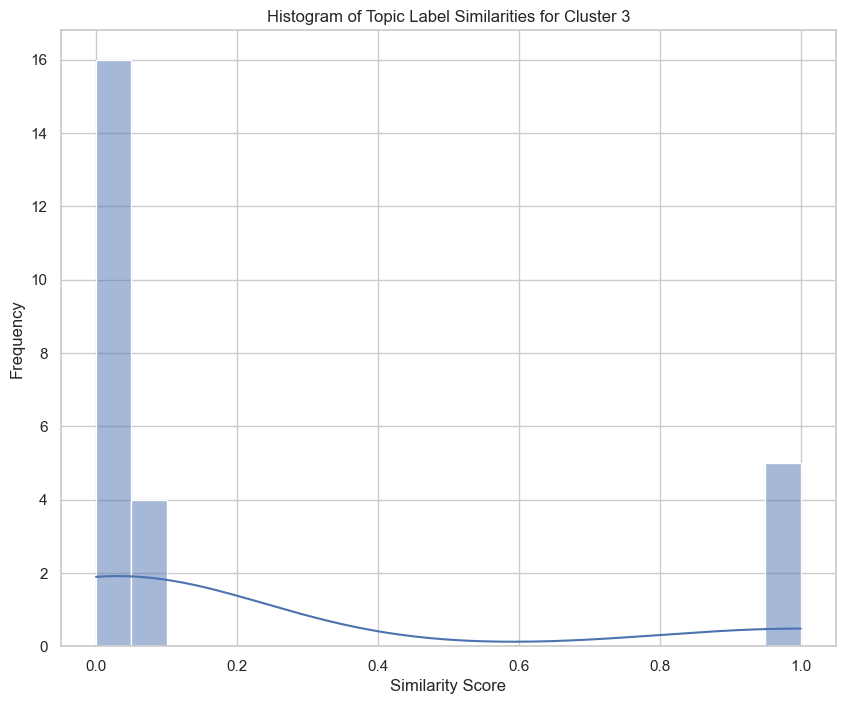

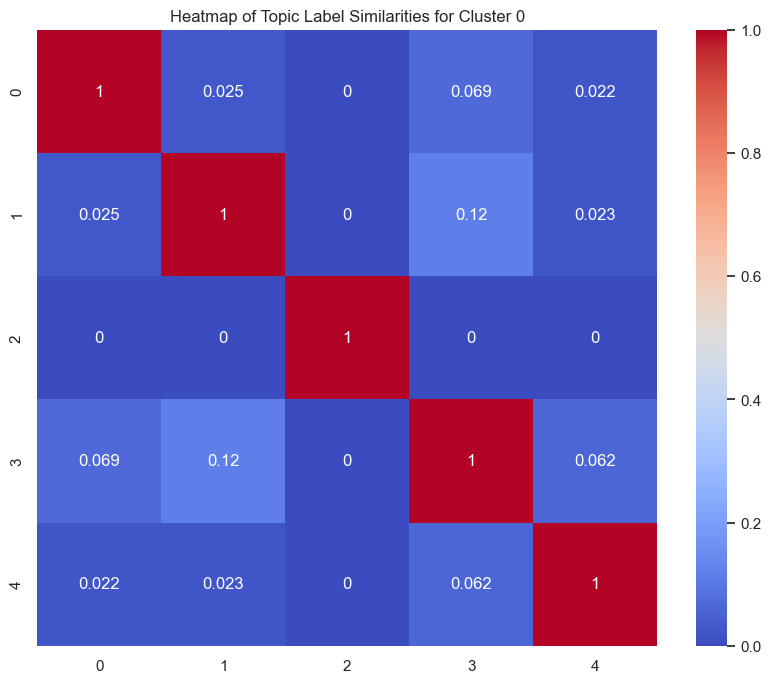

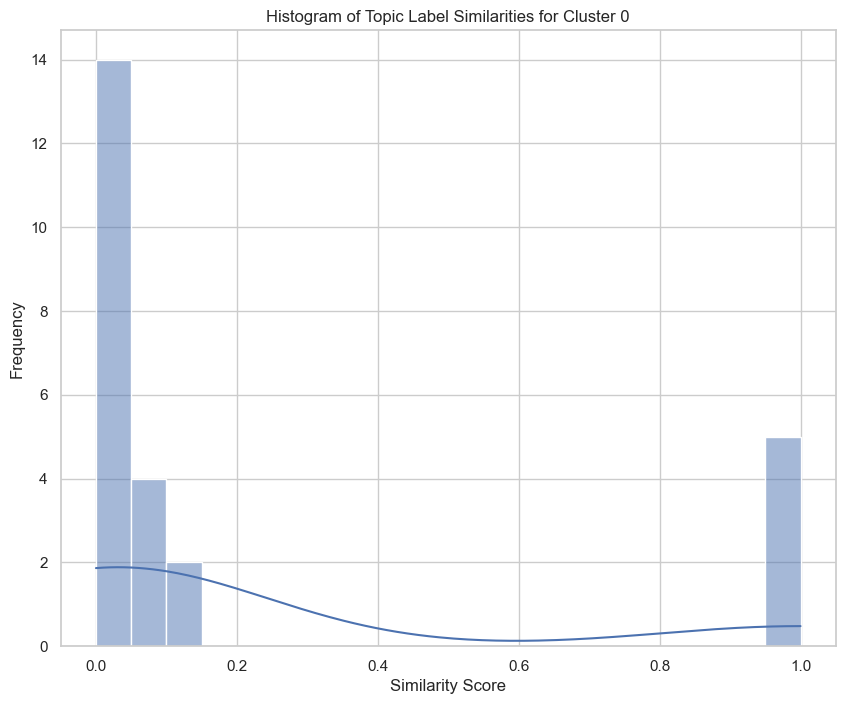

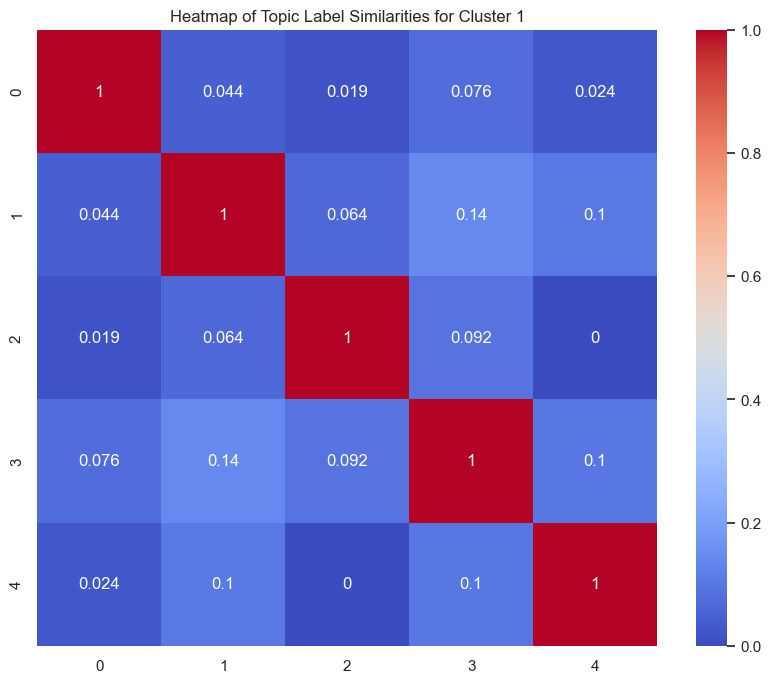

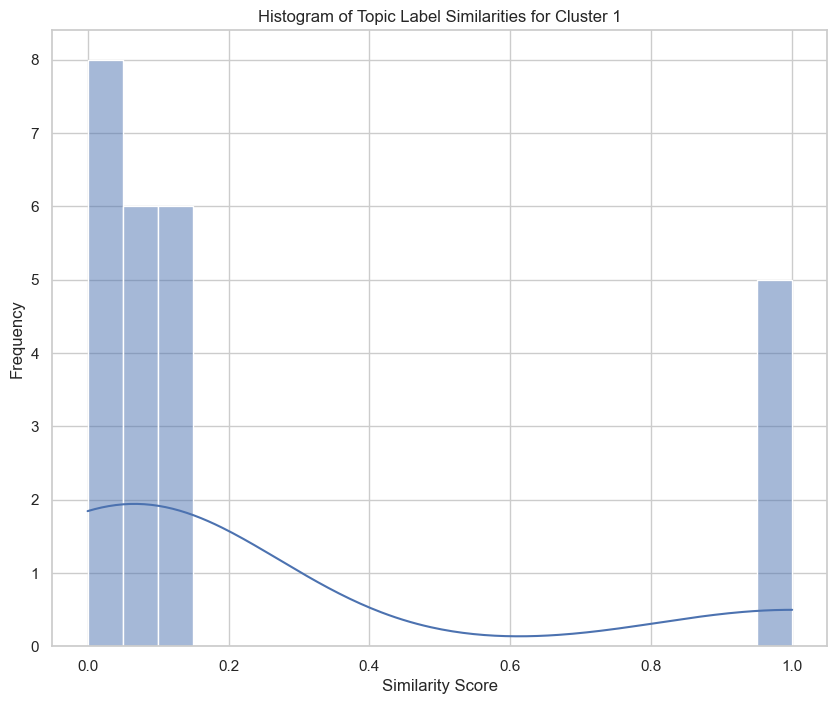

In [74]:
# Initialize the class with the toy dataset
cluster_identifier = ClusterTopicIdentifier(df, text_col='Description', cluster_col='kmeans_label')

# Identify topics for each cluster
result_df  = cluster_identifier.identify_topics()

# Visualize the topic stability
cluster_identifier.visualize_runs(result_df )

In [75]:
result_df

,Cluster,Topic Labels,Similarity
0,2,"[1. ""The United Nations is seeking a resolutio...",0.244945
1,3,"[1. ""People should minimize their impact on th...",0.224608
2,0,"[Text Sample 1:\n\n""I can't believe how much I...",0.225718
3,1,"[Text Sample 1:\n""The US president has spoken ...",0.253212


In [ ]:
assert 1 + 1 == 3

AssertionError: 

In [ ]:
def identify_original_documents(documents, chunks):
    """
    This function identifies the original document(s) each chunk came from.
    Args:
    documents: A list of original documents.
    chunks: A list of text chunks.
    Returns:
    chunks: The provided chunks with appended page info.
    """
    # Combine all documents into a single string and track their ranges.
    long_string = ""
    pages_dict = {}
    for i, doc in enumerate(documents):
        start = len(long_string)
        long_string += doc.text
        end = len(long_string)
        pages_dict[i] = (start, end)

    # Identify the original document(s) for each chunk.
    for i, chunk in enumerate(chunks):
        chunk_start = long_string.find(chunk.text)
        chunk_end = chunk_start + len(chunk.text)
        pages = []
        for doc_number, (doc_start, doc_end) in pages_dict.items():
            if (chunk_start >= doc_start and chunk_start < doc_end) or (chunk_end > doc_start and chunk_end <= doc_end):
                pages.append(doc_number + 1)
        # Update existing metadata dictionary
        chunk.metadata.update({'pages': ', '.join(map(str, pages))})

    return chunks


In [ ]:
from sklearn.cluster import KMeans

n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, init="k-means++", random_state=42)
kmeans.fit(df['embedding'].to_list())
df = df.assign(cluster=kmeans.labels_)
df.head()

c:\Users\pdoub\Desktop\python_projects\junk-drawer\.venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Unnamed: 0,Title,Company,Location,Rating,Date,Salary,Description,Links,Descriptions,token_count,embedding,cluster
0,0,Data Scientist,Driven Brands,"Benicia, CA",2.4,PostedPosted 26 days ago,NaN,You’ll be working alongside a team of eight an...,https://www.indeed.com/rc/clk?jk=74d176d595225...,We invite you to join us at Driven Brands!\nHe...,26,"[-0.0194996390491724, -0.0041993726044893265, ...",2
1,1,Business Analyst,Sabot Consulting,Remote,NaN,PostedPosted 4 days ago,$80 - $120 an hour,Preferred candidates will have prior experienc...,https://www.indeed.com/rc/clk?jk=f662b2efb509b...,Sabot Consulting (Sabot) is a management consu...,25,"[-0.012073525227606297, -0.026480479165911674,...",4
2,2,IT Business Intelligence Developer (FT) Remote...,Ballad Health,"Remote in Blountville, TN",3.0,PostedPosted 30+ days ago,NaN,Job Details Apply Save Print this job Email a…,https://www.indeed.com/rc/clk?jk=58612836c63b8...,Job Details\nApply\nSave\nPrint this job\nEmai...,10,"[-0.021908748894929886, -0.002960818586871028,...",4
3,3,Data Engineer,Longevity Holdings Inc.,"Remote in Minneapolis-Saint Paul, MN",NaN,PostedPosted 3 days ago,"$90,000 - $110,000 a year",Incorporate core data management competencies ...,https://www.indeed.com/company/TwentyFirst/job...,Position: Data Engineer\nLocation: MN\nAs a Da...,29,"[-0.017482835799455643, -0.01076465379446745, ...",7
4,4,Network Administrator/dba developer,WKI Kenworth,"Wichita, KS 67219",NaN,EmployerActive 2 days ago,"$50,000 - $70,000 a year",The Network Administrator provides 2nd level e...,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,Full Job Description\nThe Network Administrato...,28,"[0.0011398864444345236, -0.0008925285073928535...",0


In [ ]:
df.Title.nunique()

566

(1200, 1536)


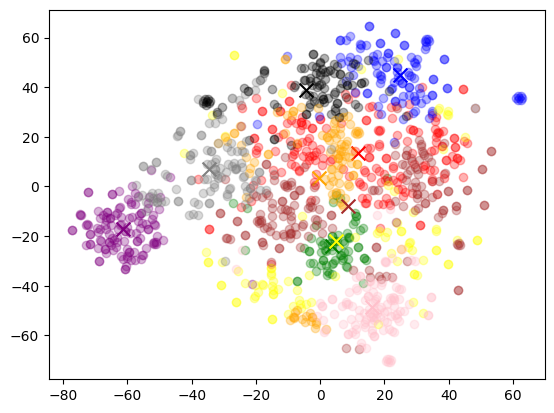

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(
    n_components=2, perplexity=15, random_state=42, init="random", learning_rate=200
)

matrix = np.vstack(df.embedding.values)
print(matrix.shape)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x, y in vis_dims2]
y = [y for x, y in vis_dims2]

for category, color in enumerate(["purple", "green", "red", "blue","yellow", 'black', 'orange', 'brown', 'pink', 'grey']):
    xs = np.array(x)[df.cluster == category]
    ys = np.array(y)[df.cluster == category]
    plt.scatter(xs, ys, color=color, alpha=0.3)

    avg_x = xs.mean()
    avg_y = ys.mean()

    plt.scatter(avg_x, avg_y, marker="x", color=color, s=100)

In [ ]:
# take 10 samples from each cluster and write a prompt that asks what these have in common
# ideally you would use more than 10, but this is just a demo
for i in range(n_clusters):
    reviews = df[df['cluster'] == i]['Description'].sample(10)
    reviews = "\n".join(reviews.values.tolist())
    
    prompt = f"Here are 10 job descriptions:\n{reviews}Write a 3 to 5 word topic reflecting what these have in common."
    #print(prompt)
    response = openai.Completion.create(model="text-davinci-003", prompt=prompt, temperature=0.15, max_tokens=100, top_p=1, frequency_penalty=0, presence_penalty=0, stop=None)['choices'][0]['text'].strip()
    print(f"Cluster {i} topics: {response}")
    jobs = df[df['cluster'] == i]['Title'].sample(25)
    print(f"Jobs from cluster {i}: {', '.join(jobs.values.tolist())}")
    print("================")

Cluster 0 topics: Database Administration.
Jobs from cluster 0: Database Administrator, Database Administrator (Direct Hire/Remote), Database Administrator - Oracle (100% Remote), Oracle Database Administrator, Database Administrator, Database Administrator, Database Administrator II, DATABASE ADMINISTRATOR- SQL SERVER- CLT/REMOTE, SQL Server Database Administrator II - (Remote from anywhere in CO), Database Administrator, DATABASE ADMINISTRATOR, Database Administrator, Database Administrator 2, Database Administrator - Open to 100% Remote, Junior SQL Server Database Administrator, Database Administrator, IT Database Administrator / Senior Administrator, Database Administrator, Database Specialist, SQL Server/Db2 Database Administrator, Jr. SQL Database Administrator, Database Administrator, Database Administrator 5, SQL Database Administrator, Database Administrator
Cluster 1 topics: Business Intelligence Tools.
Jobs from cluster 1: Junior Developer – Business Intelligence (ETL), Busi

In [ ]:
ds_job = "Data Scientist"

# get embedding for movie
e = df[df['Title'] == ds_job]['embedding'].values[0]

# get cosine similarity between movie and all other movies and sort ascending
similarities = df['embedding'].apply(lambda x: cosine_similarity(x, e))

# get most similar movies
movies = df.assign(similarity=similarities).sort_values(by='similarity', ascending=False)[['Title', 'similarity', 'Description']]
movies[1:10]

,Title,similarity,Description
763,"Manager, Data Science & Analytics, Central Ana...",0.915978,"You will collaborate with data engineers, data..."
1130,"Manager, Data Science",0.908001,You will work to develop data science solution...
77,Data Scientist,0.902445,You will be a member of a multidisciplinary te...
1159,Data Scientist,0.902279,You will be a member of a multidisciplinary te...
236,"Senior Software Development Engineer, Big Data",0.900152,"Collaborate with engineers, product managers, ..."
354,Data Scientist,0.897500,"Work closely with analysts, traders, developer..."
149,Data Scientist,0.895616,You'll work closely with other data scientists...
326,Data Science Lead,0.890732,"As a Lead, you will be leading and growing a t..."
398,Data Engineer,0.886443,Collaborate with data analysts/scientists and ...


In [ ]:
from llama_index import SimpleDirectoryReader, ServiceContext, KnowledgeGraphIndex, StorageContext
from llama_index.graph_stores import SimpleGraphStore
from llama_index.llms import OpenAI
from IPython.display import Markdown, display

In [ ]:
from pathlib import Path

documents = SimpleDirectoryReader(input_files=['./data/HO3_sample.pdf']).load_data()

In [ ]:
llm=OpenAI(temperature=0, model_name="gpt-4")
service_context = ServiceContext.from_defaults(llm=llm, chunk_size_limit=512)

graph_store = SimpleGraphStore()
storage_context = StorageContext.from_defaults(graph_store=graph_store)

In [ ]:
index = KnowledgeGraphIndex.from_documents(
    documents,
    max_triplets_per_chunk=10,
    storage_context=storage_context,
    service_context=service_context,
    include_embeddings=True
)

index.set_index_id("ho3_kg_index")
index.storage_context.persist(persist_dir="./ho3_kg_index")

In [ ]:
index.storage_context.persist(persist_dir="./ho3_kgraph_index.json")

In [ ]:
query_engine = index.as_query_engine(
    include_text=True,
    response_mode="tree_summarize",
    embedding_mode="hybrid",
    similarity_top_k=5,
)

In [ ]:
response = query_engine.query(
    "Tell me more about Personal Propery coverage", 
)

In [ ]:
display(Markdown(f"{response}"))


Personal Property coverage under the HO3_sample.pdf policy provides coverage for personal property owned or used by an insured while it is anywhere in the world. This coverage applies to personal property owned by or rented to an insured, and includes property that has been removed from the premises. The policy covers the risk of direct physical loss, but excludes losses caused by certain perils such as aircraft, motor vehicles, and losses excluded under Section I - Exclusions. Losses are settled as actual cash value, which is the cost to replace the property with material of like kind and quality, less depreciation. The policy also has a special limit of liability for each category of personal property, such as $200 for money, bank notes, bullion, gold other than goldware, silver other than silverware, platinum other than platinumware, coins, medals, scrip, stored value cards and smart cards, and $1,500 for securities, accounts, deeds, evidences of debt, letters of credit, notes other than bank notes, manuscripts, personal records, passports, tickets and stamps.

In [ ]:
from pyvis.network import Network

g = kg_index.get_networkx_graph()
net = Network(notebook=True, cdn_resources="in_line", directed=True)
net.from_nx(g)

In [ ]:
net.write_html("ho3_kg.html")

In [ ]:
from llama_index import StorageContext, load_index_from_storage

storage_context = StorageContext.from_defaults(persist_dir="./ho3_kg_index")

kg_index  = load_index_from_storage(storage_context)

In [ ]:
import json
import networkx as nx
from community import community_louvain

In [ ]:
# Create a NetworkX graph from the KG
graph = nx.MultiDiGraph()
rel_map = kg_index.index_struct.rel_map
for node, edges in rel_map.items():
    for edge in edges:
        graph.add_edge(node, edge[0], label=edge[1])

In [ ]:
# Split the graph into subgraphs using the Louvain method
def split_graph_using_louvain(graph):
    partition = community_louvain.best_partition(graph)
    subgraphs = {}

    for node, community in partition.items():
        if community not in subgraphs:
            subgraphs[community] = []
        subgraphs[community].append(node)

    subgraph_list = [graph.subgraph(nodes) for nodes in subgraphs.values()]
    
    return subgraph_list

In [ ]:
graph_xd = graph.to_undirected()

In [ ]:
subgraphs = split_graph_using_louvain(graph_xd)

In [ ]:
# Get embeddings for each subgraph
subgraph_embeddings = []
for subgraph in subgraphs:
    documents = [kg_index.docstore.docs[doc_id] for doc_id in subgraph.nodes]
    subgraph_index = KnowledgeGraphIndex.from_documents(
        documents,
        max_triplets_per_chunk=2,
        service_context=service_context,
        include_embeddings=True
    )
    embedding = subgraph_index.get_embedding()
    subgraph_embeddings.append(embedding)

In [ ]:
G = nx.erdos_renyi_graph(100, 0.01)
partion = community_louvain.best_partition(G)

In [ ]:
import pandas as pd

df = pd.DataFrame({'louvian_community_label': partion})

In [ ]:
df

,louvian_community_label
0,0
1,1
2,2
3,3
4,11
...,...
95,43
96,30
97,43
98,22


In [ ]:
graph = nx.MultiDiGraph()
rel_map = kg_index.index_struct.rel_map
for node, edges in rel_map.items():
    for edge in edges:
        graph.add_edge(node, edge[0], label=edge[1])

In [ ]:
def split_graph_using_louvain(graph):
    partition = community_louvain.best_partition(graph)
    subgraphs = {}

    for node, community in partition.items():
        if community not in subgraphs:
            subgraphs[community] = []
        subgraphs[community].append(node)

    subgraph_list = [graph.subgraph(nodes) for nodes in subgraphs.values()]
    return subgraph_list

In [ ]:
subgraphs = split_graph_using_louvain(graph)

TypeError: Bad graph type, use only non directed graph

In [ ]:
# Get embeddings for each subgraph
subgraph_embeddings = []
for subgraph in subgraphs:
    documents = [kg_index.docstore.docs[doc_id] for doc_id in subgraph.nodes]
    subgraph_index = KnowledgeGraphIndex.from_documents(
        documents,
        max_triplets_per_chunk=2,
        service_context=service_context,
        include_embeddings=True
    )
    embedding = subgraph_index.get_embedding()
    subgraph_embeddings.append(embedding)

In [ ]:
from pyvis.network import Network

g = kg_index.get_networkx_graph()
net = Network(
    notebook=True,
    directed=True,
    cdn_resources='local',
)
net.from_nx(g)

In [ ]:
net.repulsion(
    node_distance=100,
    central_gravity=0.2,
    spring_length=200,
    spring_strength=0.05,
    damping=0.09,
)

In [ ]:
net.write_html("kg_ho3.html")

In [ ]:
net = Network(
    cdn_resources='local',
    directed = True,            # directed graph
    bgcolor = "#222222",          # background color of graph 
    font_color = "white",      # use yellow for node labels
    height = "1000px",          # height of chart
    width = "100%",             # fill the entire width    
    )

net.repulsion(
    node_distance=200,
    central_gravity=0.2,
    spring_length=250,
    spring_strength=0.08,
    damping=0.1,
)
net.toggle_physics(True)
net.from_nx(g)
net.write_html("kg_ho3_34.html")

In [ ]:
from llama_index.prompts.base import Prompt
from llama_index.prompts.prompt_type import PromptType


KG_TRIPLET_EXTRACT_TMPL = (
    "Some text is provided below. Given the text, extract up to "
    "{max_knowledge_triplets} "
    "knowledge triplets in the form of (subject, predicate, object). Avoid stopwords and numbers.\n"
    "---------------------\n"
    "Example:"
    "Text: Alice is Bob's mother."
    "Triplets:\n(Alice, is mother of, Bob)\n"
    "Text: Philz is a coffee shop founded in Berkeley in 1982.\n"
    "Triplets:\n"
    "(Philz, is, coffee shop)\n"
    "(Philz, founded in, Berkeley)\n"
    "(Philz, founded in, 1982)\n"
    "---------------------\n"
    "Text: {text}\n"
    "Triplets:\n"
)
KG_TRIPLET_EXTRACT_PROMPT = Prompt(
    KG_TRIPLET_EXTRACT_TMPL, prompt_type=PromptType.KNOWLEDGE_TRIPLET_EXTRACT
)

In [ ]:
from llama_index import (
    KnowledgeGraphIndex,
    ServiceContext,
    SimpleDirectoryReader,
)
from llama_index.storage.storage_context import StorageContext
from llama_index.graph_stores import NebulaGraphStore

In [ ]:
documents = SimpleDirectoryReader(input_files=["./data/HO3_sample.pdf"]).load_data()

graph_store = SimpleGraphStore()
storage_context = StorageContext.from_defaults(graph_store=graph_store)

kg_index = KnowledgeGraphIndex.from_documents(
    documents,
    max_triplets_per_chunk=10,
    storage_context=storage_context,
    service_context=service_context,
    llm=llm,
    include_embeddings=True,
    kg_triple_extract_template=KG_TRIPLET_EXTRACT_PROMPT)

kg_index.set_index_id(str("kg_index_storage"))
kg_index.storage_context.persist(persist_dir="./kg_index_storage")

In [ ]:
from llama_index.storage.storage_context import StorageContext
from llama_index.graph_stores import SimpleGraphStore

kg_query_engine = kg_index.as_query_engine(
    storage_context=storage_context,
    service_context=service_context,
    llm=llm,
    verbose=True,
)

In [ ]:
kg_rag_query_engine = kg_index.as_query_engine(
    include_text=False,
    retriever_mode="keyword",
    response_mode="tree_summarize",
)

In [ ]:
storage_context_vector = StorageContext.from_defaults(persist_dir='./ho3_metadatas_index')
vector_index = load_index_from_storage(
    service_context=service_context,
    storage_context=storage_context_vector
)

INFO:llama_index.indices.loading:Loading all indices.


In [ ]:
vector_rag_query_engine = vector_index.as_query_engine()

In [ ]:
# import QueryBundle
from llama_index import QueryBundle

# import NodeWithScore
from llama_index.schema import NodeWithScore

# Retrievers
from llama_index.retrievers import BaseRetriever, VectorIndexRetriever, KGTableRetriever

from typing import List


class CustomRetriever(BaseRetriever):
    """Custom retriever that performs both Vector search and Knowledge Graph search"""

    def __init__(
        self,
        vector_retriever: VectorIndexRetriever,
        kg_retriever: KGTableRetriever,
        mode: str = "OR",
    ) -> None:
        """Init params."""

        self._vector_retriever = vector_retriever
        self._kg_retriever = kg_retriever
        if mode not in ("AND", "OR"):
            raise ValueError("Invalid mode.")
        self._mode = mode

    def _retrieve(self, query_bundle: QueryBundle) -> List[NodeWithScore]:
        """Retrieve nodes given query."""

        vector_nodes = self._vector_retriever.retrieve(query_bundle)
        kg_nodes = self._kg_retriever.retrieve(query_bundle)

        vector_ids = {n.node.node_id for n in vector_nodes}
        kg_ids = {n.node.node_id for n in kg_nodes}

        combined_dict = {n.node.node_id: n for n in vector_nodes}
        combined_dict.update({n.node.node_id: n for n in kg_nodes})

        if self._mode == "AND":
            retrieve_ids = vector_ids.intersection(kg_ids)
        else:
            retrieve_ids = vector_ids.union(kg_ids)

        retrieve_nodes = [combined_dict[rid] for rid in retrieve_ids]
        return retrieve_nodes

In [ ]:
from llama_index import get_response_synthesizer
from llama_index.query_engine import RetrieverQueryEngine

# create custom retriever
vector_retriever = VectorIndexRetriever(index=vector_index)
kg_retriever = KGTableRetriever(
    index=kg_index, retriever_mode="keyword", include_text=False
)
custom_retriever = CustomRetriever(vector_retriever, kg_retriever)

# create response synthesizer
response_synthesizer = get_response_synthesizer(
    service_context=service_context,
    response_mode="tree_summarize",
)

In [ ]:
graph_vector_rag_query_engine = RetrieverQueryEngine(
    retriever=custom_retriever,
    response_synthesizer=response_synthesizer,
)

In [ ]:
response_kg = kg_query_engine.query("Privide a detailed explanation of Personal Propery coverage")

Markdown(f"{response_kg}")

INFO:llama_index.indices.knowledge_graph.retriever:> Starting query: Privide a detailed explanation of Personal Propery coverage
INFO:llama_index.indices.knowledge_graph.retriever:> Query keywords: ['Detailed', 'Property', 'Explanation', 'Personal', 'Coverage']
INFO:llama_index.indices.knowledge_graph.retriever:> Querying with idx: e6c1125d-99a4-4be8-8c95-bd8290ed051b: of being operatedby other power sources.
Accessories include antennas, tapes,...
INFO:llama_index.indices.knowledge_graph.retriever:> Querying with idx: ac7c5745-d905-455a-bb36-55109d06ac03: Page 6 of 22 Copyright, Insurance Services Office, Inc., 1999 HO 00 03 10 00b...
INFO:llama_index.indices.knowledge_graph.retriever:> Querying with idx: bc960b04-4074-49c6-ba25-a40af68928cc: building unless the roof or anoutside wall of the building is first damaged b...
INFO:llama_index.indices.knowledge_graph.retriever:> Querying with idx: 002be22d-1ca5-4274-9ac4-e1ceb5e8357f: from apremises endangered by a Peril InsuredAgainst and


Personal Property coverage provides coverage for personal property owned or used by an insured while it is anywhere in the world. After a loss and at the insured's request, the policy will cover personal property owned by others while the property is on the part of the residence premises occupied by an insured, or by a guest or a residence employee while the property is in any residence occupied by an insured. The policy also provides a special limit of liability for certain categories of personal property, such as money, bank notes, bullion, gold, silver, platinum, coins, medals, scrip, stored value cards, securities, accounts, deeds, evidences of debt, letters of credit, notes, manuscripts, personal records, passports, tickets, and stamps. This limit includes the cost to research, replace, or restore the information from the lost or damaged property. The policy also provides coverage for personal property moved from the residence premises due to repair, renovation, or rebuilding, and for personal property in a newly acquired principal residence for 30 days from the time the insured begins to move the property there.

In [ ]:
response_kg_rag = kg_rag_query_engine.query("Privide a detailed explanation of Personal Propery coverage")

Markdown(f"{response_kg_rag}")

INFO:llama_index.indices.knowledge_graph.retriever:> Starting query: Privide a detailed explanation of Personal Propery coverage
INFO:llama_index.indices.knowledge_graph.retriever:> Query keywords: ['Detailed', 'Property', 'Explanation', 'Personal', 'Coverage']
INFO:llama_index.indices.knowledge_graph.retriever:> Extracted relationships: The following are knowledge triplets in max depth 2 in the form of `subject [predicate, object, predicate_next_hop, object_next_hop ...]`
Property ['not covered', 'motor vehicles']
Property ['not covered', 'aircraft']
Property ['not covered', 'hovercraft']
Property ['not covered', 'roomers']
Property ['not covered', 'boarders']
Property ['not covered', 'tenants']
Property ['not covered', 'apartment']
Property ['not covered', "Landlord's Furnishings"]
Property ['not covered', 'rented']
Property ['not covered', 'held']
Property ['rented or held for rental to others', 'off the "residence premises"']
Property ['covered by', 'policy']
Property ['covers', 'r


Personal Property coverage is a type of insurance that covers the loss or damage of personal belongings due to certain events, such as theft, fire, or natural disasters. This type of coverage typically applies to items that are not covered by other insurance policies, such as motor vehicles, aircraft, hovercraft, roomers, boarders, tenants, apartment, landlord's furnishings, rented or held for rental to others, and off the "residence premises".

Personal Property coverage typically covers the replacement cost of the items, up to the amount of insurance stated in the policy. The replacement cost is the cost of replacing the item with material of like kind and quality, for the same use, immediately before the loss. The insurance amount must be at least 80% of the replacement cost. The coverage may also include additional insurance with no deductible.

However, there are certain items that are excluded from Personal Property coverage, such as excavations, supports, and underground flues. Additionally, the coverage may not be in effect for less than 60 days, or if it is a renewal with the insurance company.

In [ ]:
response_vector_rag = vector_rag_query_engine.query("Privide a detailed explanation of Personal Propery coverage")

Markdown(f"{response_vector_rag}")


Personal Property coverage is a type of coverage provided by a Homeowner's Insurance policy. It covers personal property owned or used by an insured while it is anywhere in the world. This includes items such as money, securities, watercraft, trailers, jewelry, watches, furs, precious and semiprecious stones, firearms, and related equipment. The limit of liability for personal property located at an insured's residence other than the residence premises is 10% of the limit of liability for Coverage C, or $1,000, whichever is greater. There are also special limits of liability for certain categories of property, such as money, securities, watercraft, trailers, jewelry, watches, furs, precious and semiprecious stones, firearms, and related equipment. These special limits do not increase the Coverage C limit of liability.

In [ ]:
response_graph_vector_rag = graph_vector_rag_query_engine.query(
    "Privide a detailed explanation of Personal Propery coverage", 
)
Markdown(f"{response_graph_vector_rag}")

INFO:llama_index.indices.knowledge_graph.retriever:> Starting query: Privide a detailed explanation of Personal Propery coverage
INFO:llama_index.indices.knowledge_graph.retriever:> Query keywords: ['Detailed', 'Property', 'Explanation', 'Personal', 'Coverage']
INFO:llama_index.indices.knowledge_graph.retriever:> Extracted relationships: The following are knowledge triplets in max depth 2 in the form of `subject [predicate, object, predicate_next_hop, object_next_hop ...]`
Property ['not covered', 'motor vehicles']
Property ['not covered', 'aircraft']
Property ['not covered', 'hovercraft']
Property ['not covered', 'roomers']
Property ['not covered', 'boarders']
Property ['not covered', 'tenants']
Property ['not covered', 'apartment']
Property ['not covered', "Landlord's Furnishings"]
Property ['not covered', 'rented']
Property ['not covered', 'held']
Property ['rented or held for rental to others', 'off the "residence premises"']
Property ['covered by', 'policy']
Property ['covers', 'r


Personal Property coverage under a Homeowner's Insurance policy covers personal property owned or used by an insured while it is anywhere in the world. This includes personal property owned by others while it is on the part of the residence premises occupied by an insured, or by a guest or a residence employee while the property is in any residence occupied by an insured. The limit of liability for personal property located at an insured's residence other than the residence premises is 10% of the limit of liability for Coverage C, or $1,000, whichever is greater.

The policy also outlines special limits of liability for certain categories of property, such as money, securities, watercraft, trailers, jewelry, watches, furs, precious and semiprecious stones, firearms, and related equipment. These special limits do not increase the Coverage C limit of liability.

The policy also states that the deductible provision applies to all losses. This means that the insured is responsible for paying the deductible amount before the insurance company will cover the remaining costs of the loss.

In [ ]:
response